In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

import scipy
from scipy.interpolate import UnivariateSpline

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import glm
import statistics as st 

from time import time
import random

In [2]:
cd

/Users/karatechop


In [3]:
cd /Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Data/Formatted with YOE/for final analysis

/Users/karatechop/Documents/GitHub/senior-thesis-pretextual-stops/Data/Formatted with YOE/for final analysis


In [4]:
ls

ALL-BPD-AB953-DUSK-LOC.csv    ALL-OAKLAND-AB953-DUSK.csv
ALL-BPD-AB953-DUSK.csv        ALL-SDPD-AB953-DUSK.csv
ALL-MARIN-AB953-DUSK-LOC.csv  ALL-SFPD-AB953-DUSK-LOC.csv
ALL-MARIN-AB953-DUSK.csv      sf_pops_zips.csv


In [5]:
SDPD_count = pd.read_csv('ALL-SDPD-AB953-DUSK.csv')
print(SDPD_count['date'].min())
print(SDPD_count.shape)
print(SDPD_count[SDPD_count['itp']==1].shape)
print(SDPD_count[SDPD_count['itp']==1]['dark'].value_counts())

2018-07-01
(104512, 14)
(35826, 14)
0    20787
1    15039
Name: dark, dtype: int64


In [6]:
SFPD_count = pd.read_csv('ALL-SFPD-AB953-DUSK-LOC.csv')
print(SFPD_count['date'].min())
print(SFPD_count.shape)
print(SFPD_count[SFPD_count['itp']==1].shape)
print(SFPD_count[SFPD_count['itp']==1]['dark'].value_counts())

2018-07-01
(21324, 18)
(21324, 18)
0    13033
1     8291
Name: dark, dtype: int64


# MODELS

## SDPD

In [88]:
SDPD['race'].value_counts()

hispanic/latino/a                36697
white                            35782
black/african american           18531
asian                             7857
middle eastern or south asian     4577
pacific islander                   915
native american                    153
Name: race, dtype: int64

In [212]:
len(SDPD_VOD['location'].unique())

125

In [211]:
len(SFPD_VOD['zip'].unique())

29

In [227]:
SDPD = pd.read_csv('ALL-SDPD-AB953-DUSK.csv')
sd_group = 'hispanic/latino/a'
SDPD_VOD = SDPD[(SDPD['itp']==1)&
               ((SDPD['mins_before_dusk']>30) | (SDPD['mins_before_dusk']<0)) &
               ((SDPD['race']=='black/african american')|
                   (SDPD['race']=='hispanic/latino/a')|
                   (SDPD['race']=='white')|
                   (SDPD['race']=='asian')|
                   (SDPD['race']=='middle eastern or south asian'))]

#https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/
vod_SD_dusk = pd.get_dummies(SDPD_VOD, columns = ['race'], drop_first=False, prefix='')\
                       [['date',
                         'mins_stop_time',
                         'location',
                         'Experience',
                         'dark',
                         f'_{group}']].reset_index(drop=True)\
                                                    .rename(columns={f'_{group}':'minority'})


# vod_SF_dusk['Experience'] = vod_SF_dusk['Experience'].astype(int)
vod_SD_dusk['mins_stop_time'] = vod_SD_dusk['mins_stop_time'].astype(int)
vod_SD_dusk['location'] = vod_SD_dusk['location'].astype(str)

sd_loc_table = vod_SD_dusk.groupby('location',as_index=False).agg('count')\
                                                             .rename(columns={'date':'count'})\
                                                             .iloc[:,:2]
sd_loc_table.describe()
sd_loc_table['freq'] = ''
sd_loc_table['count'].describe()
sd_loc_table.loc[sd_loc_table['count']<75,'freq']='low_freq'
sd_loc_table.loc[(sd_loc_table['count']>=75)&(sd_loc_table['count']<=275),'freq']='average'
sd_loc_table.loc[(sd_loc_table['count']>275),'freq']='high_freq'
sd_loc_table = sd_loc_table.sort_values(by='count',ascending=False).reset_index(drop=True)
sd_loc_table.head()

vod_SD_dusk = vod_SD_dusk.merge(sd_loc_table[['location','freq']],on='location')


def custom_round(x, base=5):
    return int(base * round(float(x)/base))

vod_SD_dusk['mins_stop_time'] = [custom_round(i,base=5) for i in vod_SD_dusk['mins_stop_time']]


# Create a natural spline with 6 degrees of freedom using the time variable and the dependent variable
spline = UnivariateSpline(vod_SD_dusk.index.values, vod_SD_dusk['mins_stop_time'], k=5, s=0.3)

# Add the natural spline as a predictor to the DataFrame
vod_SD_dusk['time_spline_df6'] = spline(vod_SD_dusk.index)

model_list_SD = [glm('minority ~ C(dark) + time_spline_df6', data=vod_SD_dusk, family=sm.families.Binomial()),
                 glm('minority ~ C(dark) + time_spline_df6 + C(freq)', data=vod_SD_dusk, family=sm.families.Binomial()),
                 glm('minority ~ C(dark) + time_spline_df6 + C(freq) + Experience', data=vod_SD_dusk, family=sm.families.Binomial())]

vod_SD_dusk.head()

,date,mins_stop_time,location,Experience,dark,minority,freq,time_spline_df6
0,2018-07-15,1170,313.0,26,0,0,high_freq,1170.000001
1,2019-02-07,1035,313.0,28,0,0,high_freq,1034.999991
2,2019-02-07,1085,313.0,28,1,0,high_freq,1085.000033
3,2019-02-07,1110,313.0,18,1,1,high_freq,1109.999925
4,2019-02-07,1125,313.0,28,1,0,high_freq,1125.000123


In [230]:
print(sd_group)
model_list_SD[2].fit().summary()

hispanic/latino/a


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               minority   No. Observations:                31095
Model:                            GLM   Df Residuals:                    31089
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20173.
Date:                Sat, 10 Dec 2022   Deviance:                       40346.
Time:                        20:38:21   Pearson chi2:                 3.11e+04
No. Iterations:                     4   Pseudo R-squ. (CS):           0.001742
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.6012      0.269      2.233      0.026       0.073       1.129
C(dark)[T.1]             0.1185      0.028      4.233      0.000       0.064       0.173
C(freq)[T.high_freq]     0.1253      0.027      4.598      0.000       0.072       0.179
C(freq)[T.low_freq]     -0.0623      0.065     -0.959      0.337      -0.190       0.065
time_spline_df6         -0.0012      0.000     -4.856      0.000      -0.002      -0.001
Experience              -0.0014      0.002     -0.857      0.392      -0.005       0.002
========================================================================================
"""

In [229]:
OR = pd.DataFrame(
    {
        "OR": model_list_SD[1].fit().params,
        "Lower CI": model_list_SD[1].fit().conf_int()[0],
        "Upper CI": model_list_SD[1].fit().conf_int()[1],
    },
)
OR = np.exp(OR)

print(group,'\n\n')
print(f'{OR}\n\n\n{model_list_SD[1].fit().summary()}\n\n\n\n\n\n\n\n\n')

hispanic/latino/a 


                            OR  Lower CI  Upper CI
Intercept             1.807910  1.067045  3.063168
C(dark)[T.1]          1.127663  1.067569  1.191140
C(freq)[T.high_freq]  1.129849  1.071625  1.191236
C(freq)[T.low_freq]   0.938519  0.826412  1.065834
time_spline_df6       0.998811  0.998331  0.999291


                 Generalized Linear Model Regression Results                  
Dep. Variable:               minority   No. Observations:                31095
Model:                            GLM   Df Residuals:                    31090
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -20173.
Date:                Sat, 10 Dec 2022   Deviance:                       40347.
Time:                        20:37:45   Pearson chi2:                 3.11e+04
No. Iterations:                     4  

## SFPD

In [143]:
SFPD[SFPD['itp']==1]['race'].value_counts()

white                            7239
black/african american           4294
hispanic/latino(a)               3673
asian                            3150
middle eastern or south asian    2299
mixed                             417
pacific islander                  226
native american                    26
Name: race, dtype: int64

In [234]:
SFPD = pd.read_csv('ALL-SFPD-AB953-DUSK-LOC.csv')

group = 'black/african american'
SFPD_VOD = SFPD[(SFPD['itp']==1)&
               ((SFPD['mins_before_dusk']>30) | (SFPD['mins_before_dusk']<0)) &
               ((SFPD['race']=='black/african american')|
                    (SFPD['race']=='hispanic/latino(a)')|
                    (SFPD['race']=='white')|
                    (SFPD['race']=='asian')|
                    (SFPD['race']=='middle eastern or south asian'))]


#https://www.geeksforgeeks.org/ml-one-hot-encoding-of-datasets-in-python/
vod_SF_dusk = pd.get_dummies(SFPD_VOD, columns = ['race'], drop_first=False, prefix='')\
                       [['date',
                         'mins_stop_time',
                         'zip',
                         'Experience',
                         'dark',
                         f'_{group}']].reset_index(drop=True)\
                                                    .rename(columns={f'_{group}':'minority',
                                                                      'zip':'location'})


# vod_SF_dusk['Experience'] = vod_SF_dusk['Experience'].astype(int)
vod_SF_dusk['mins_stop_time'] = vod_SF_dusk['mins_stop_time'].astype(int)
vod_SF_dusk['location'] = vod_SF_dusk['location'].astype(str)

pop_zips = pd.read_csv('sf_pops_zips.csv').iloc[1:,:].rename(columns={'zip':'location'})
vod_SF_dusk = vod_SF_dusk.merge(pop_zips,on='location').sort_values(by='date').reset_index(drop=True)
vod_SF_dusk['pop'] = vod_SF_dusk['pop'].astype(int)

vod_SF_dusk['mins_stop_time'] = [custom_round(i,base=5) for i in vod_SF_dusk['mins_stop_time']]

vod_SF_dusk['pop_cat'] = 'average'
vod_SF_dusk.loc[vod_SF_dusk['pop']<35403-19787,'pop_cat'] = 'low'
vod_SF_dusk.loc[vod_SF_dusk['pop']>35403+19787,'pop_cat'] = 'high'


sf_loc_table = vod_SF_dusk.groupby('location',as_index=False).agg('count')\
                                                             .rename(columns={'date':'count'})\
                                                             .iloc[:,:2]


sf_loc_table['freq'] = 'average'
sf_loc_table['count'].describe()
sf_loc_table.loc[sf_loc_table['count']<60,'freq']='low_freq'
sf_loc_table.loc[(sf_loc_table['count']>=60)&(sd_loc_table['count']<=230),'freq']='average'
sf_loc_table.loc[(sf_loc_table['count']>230),'freq']='high_freq'
sf_loc_table = sf_loc_table.sort_values(by='count',ascending=False).reset_index(drop=True)
sf_loc_table.head()

vod_SF_dusk = vod_SF_dusk.merge(sf_loc_table[['location','freq']],on='location')
vod_SF_dusk['mins_stop_time'] = [custom_round(i,base=5) for i in vod_SF_dusk['mins_stop_time']]



# Create a natural spline with 6 degrees of freedom using the time variable and the dependent variable
spline = UnivariateSpline(vod_SF_dusk.index.values, vod_SF_dusk['mins_stop_time'], k=5, s=0.3)

# Add the natural spline as a predictor to the DataFrame
vod_SF_dusk['time_spline_df6'] = spline(vod_SF_dusk.index)

model_list_SF = [glm('minority ~ C(dark) + time_spline_df6', data=vod_SF_dusk, family=sm.families.Binomial()),
                 glm('minority ~ C(dark) + time_spline_df6 + C(pop_cat) + C(freq)', data=vod_SF_dusk, family=sm.families.Binomial()),
                 glm('minority ~ C(dark) + time_spline_df6 + C(pop_cat) + C(freq) + Experience', data=vod_SF_dusk, family=sm.families.Binomial())]

vod_SF_dusk.head()

,date,mins_stop_time,location,Experience,dark,minority,pop,pop_cat,freq,time_spline_df6
0,2018-07-01,1175,94122,5.0,0,0,52828,average,high_freq,1175.000015
1,2018-07-01,1105,94122,2.0,0,0,52828,average,high_freq,1104.999886
2,2018-07-01,1065,94122,2.0,0,0,52828,average,high_freq,1065.000403
3,2018-07-02,1155,94122,4.0,0,0,52828,average,high_freq,1154.999113
4,2018-07-02,1080,94122,1.0,0,0,52828,average,high_freq,1080.001389


In [235]:
print(group)
print(model_list_SF[2].fit().summary())

black/african american
                 Generalized Linear Model Regression Results                  
Dep. Variable:               minority   No. Observations:                19192
Model:                            GLM   Df Residuals:                    19184
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9798.7
Date:                Sun, 11 Dec 2022   Deviance:                       19597.
Time:                        20:48:57   Pearson chi2:                 1.92e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.01940
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept

In [223]:
OR = pd.DataFrame(
    {
        "OR": model_list_SF[2].fit().params,
        "Lower CI": model_list_SF[2].fit().conf_int()[0],
        "Upper CI": model_list_SF[2].fit().conf_int()[1],
    },
)
OR = np.exp(OR)

print(group,'\n\n')
print(f'{OR}\n\n\n{model_list_SF[2].fit().summary()}\n\n\n\n\n\n\n\n\n')

hispanic/latino(a) 


                            OR  Lower CI  Upper CI
Intercept             0.094001  0.042302  0.208880
C(dark)[T.1]          0.907722  0.832553  0.989678
C(pop_cat)[T.high]    2.430796  2.223534  2.657378
C(pop_cat)[T.low]     1.034638  0.917983  1.166117
C(freq)[T.high_freq]  0.847092  0.680073  1.055130
C(freq)[T.low_freq]   0.432123  0.128813  1.449627
time_spline_df6       1.000805  1.000114  1.001496
Experience            0.996412  0.991343  1.001507


                 Generalized Linear Model Regression Results                  
Dep. Variable:               minority   No. Observations:                19192
Model:                            GLM   Df Residuals:                    19184
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8977.9
Date:                Sat, 10 Dec 2022   Dev

## PRIOR PERCEPTION EDA 

In [17]:
from scipy import stats
from scipy.stats import bootstrap

In [18]:
def bootstrap_mean(df, varname):
    bootstrapped = df.sample(n=len(df), replace=True)
    return bootstrapped[varname].mean()


def group_ci_by_day_of_year(df,dt_col):
    strapped_daily_means = []
    strapped_daily_itp_means = []
    
    # Creates relevant datetime columns to later group by
    df[dt_col] = pd.to_datetime(df[dt_col])
    df['day_of_month'] = pd.to_datetime(df['date']).dt.day
    df['day_of_year'] = pd.to_datetime(df['date']).dt.strftime('%j')
    df['hod2_rounded'] = ['{}:{:02d}'.format(r.hour, (r.minute//30)*30) for r in pd.to_datetime(df['time'])]
    
    
    
    # Creates a version of the dataframe counting stops by day of year, and bootsraps a daily CI
    df_grouped = df[['day_of_year','date']].groupby('day_of_year',as_index=False)['date']\
                                           .count()\
                                           .rename(columns={'date':'count'})
    for i in range(10000):
        mean = bootstrap_mean(df_grouped,'count')
        strapped_daily_means.append(mean)
    
    SE = np.std(strapped_daily_means).round(2)
    CI95 = np.percentile(strapped_daily_means, [5, 95]).round(0).astype(int)
    print(f"daily stops standard error: {SE}\n\nCI: {CI95}\n\n\n")    
    
    
    # Repeats the above but bootstraps a daily CI for ITP stops
    df_itp_grouped = df[['day_of_year','itp']].groupby('day_of_year',as_index=False)['itp']\
                                               .sum()\
                                               .rename(columns={'itp':'itps count'})
    
    
    for i in range(10000):
        mean = bootstrap_mean(df_itp_grouped,'itps count')
        strapped_daily_itp_means.append(mean)
    
    SE_itp = np.std(strapped_daily_itp_means).round(2)
    CI95_itp = np.percentile(strapped_daily_itp_means, [5, 95]).round(2).astype(int)
    print(f"daily ITP stops standard error: {SE_itp}\n\nCI: {CI95_itp}")  
    

    # Returns the new dfs for use
    return df,df_grouped,df_itp_grouped

### Files

In [402]:
OAK = pd.read_csv('ALL-OAKLAND-AB953-DUSK.csv')
print(OAK['date'].min())
print(OAK.shape)
print(OAK[OAK['itp']==1].shape)
print(OAK[OAK['itp']==1]['dark'].value_counts())

OAK['race'] = OAK['race'].str.lower()
OAK['hour'] = pd.to_datetime(OAK['time']).dt.hour
OAK, OAK_grouped, OAK_itp_grouped = group_ci_by_day_of_year(OAK,'date')
OAK_itp_grouped

2017-03-20
(10817, 15)
(1859, 15)
0    1249
1     610
Name: dark, dtype: int64
daily stops standard error: 0.98

CI: [28 31]



daily ITP stops standard error: 0.23

CI: [4 5]


,day_of_year,itps count
0,001,2
1,002,4
2,003,4
3,004,5
4,005,1
...,...,...
361,362,1
362,363,3
363,364,1
364,365,16


In [513]:
MARIN[MARIN['itp']==1]['time'].max()

'1900-01-01 21:10:00'

In [446]:
BERK = pd.read_csv('ALL-BPD-AB953-DUSK.csv')
BERK['race perceived prior'] = BERK['race perceived prior'].astype(str)

BERK['race'] = BERK['race'].str.lower()
BERK['hour'] = pd.to_datetime(BERK['time']).dt.hour

# berk_zips = [str(i) for i in np.arange(94701,94713,1)]
# berk_zips.remove('94711')
# berk_zips.append('94720')

# def berk_loc_randomize(zip_code):
#     zip_code = str(zip_code)  # Convert zip_code to a string
#     if len(zip_code) != 5 or not zip_code.startswith('947'):
#         BERK.loc[BERK['zip']==zip_code,'zip'] = random.choice(berk_zips)
#     else:
#         zip_code = zip_code
    
#     return zip_code

# BERK['zip'] = [berk_loc_randomize(zip_code) for zip_code in BERK['zip']]
print(BERK['date'].min())
print(BERK.shape)
print(BERK['dark'].value_counts())

2020-10-01
(6466, 15)
0    4493
1    1973
Name: dark, dtype: int64


In [24]:
BERK, BERK_grouped, BERK_itp_grouped = group_ci_by_day_of_year(BERK,'date')
BERK_itp_grouped

daily stops standard error: 0.56

CI: [17 19]



daily ITP stops standard error: 0.16

CI: [2 3]


,day_of_year,itps count
0,001,2
1,002,5
2,003,6
3,004,1
4,005,1
...,...,...
361,362,0
362,363,1
363,364,0
364,365,4


In [479]:
MARIN = pd.read_csv('ALL-MARIN-AB953-DUSK.csv')
MARIN['race'] = MARIN['race'].str.lower()
MARIN['hour'] = pd.to_datetime(MARIN['time']).dt.hour

print(MARIN.shape)
print(MARIN['dark'].value_counts())

(5526, 16)
0    3409
1    2117
Name: dark, dtype: int64


In [480]:
MARIN, MARIN_grouped, MARIN_itp_grouped = group_ci_by_day_of_year(MARIN,'date')
MARIN = MARIN[~MARIN['race perceived prior'].isna()]
MARIN_itp_grouped

daily stops standard error: 0.48

CI: [14 16]



daily ITP stops standard error: 0.11

CI: [2 2]


,day_of_year,itps count
0,001,3
1,002,4
2,003,5
3,004,1
4,005,1
...,...,...
361,362,1
362,363,1
363,364,1
364,365,2


In [27]:
print(f'OAK Total: {OAK.shape[0]} \
      \nOAK Prior Reported: {OAK.shape[0] - OAK["race perceived prior"].isna().sum()} \ \
      \nOAK ITP Reported: {OAK[OAK["itp"]==1].shape[0]}\
      \nOAK Prior Yes: {OAK[OAK["race perceived prior"]=="Yes"].shape[0]}\
      \nOAK Prior No: {OAK[OAK["race perceived prior"]=="No"].shape[0]}\n\n')

print(f'Berkeley Total: {BERK.shape[0]} \
      \nBerkeley Prior Reported: {BERK.shape[0] - BERK["race perceived prior"].isna().sum()} \ \
      \nBerkeley ITP Reported: {BERK[BERK["itp"]==1].shape[0]}\
      \nBerkeley Prior Yes: {BERK[BERK["race perceived prior"]=="True"].shape[0]}\
      \nBerkeley Prior No: {BERK[BERK["race perceived prior"]=="False"].shape[0]}\n\n')

print(f'Marin Total: {MARIN.shape[0]} \
      \nMarin Prior Reported: {MARIN.shape[0] - MARIN["race perceived prior"].isna().sum()} \ \
      \nMARIN ITP Reported: {MARIN[MARIN["itp"]==1].shape[0]}\
      \nMarin Prior Yes: {MARIN[MARIN["race perceived prior"]=="Yes"].shape[0]}\
      \nMarin Prior No: {MARIN[MARIN["race perceived prior"]=="No"].shape[0]}')

OAK Total: 10817       
OAK Prior Reported: 10817 \       
OAK ITP Reported: 1859      
OAK Prior Yes: 2986      
OAK Prior No: 7831


Berkeley Total: 6466       
Berkeley Prior Reported: 6466 \       
Berkeley ITP Reported: 1090      
Berkeley Prior Yes: 1125      
Berkeley Prior No: 5341


Marin Total: 3234       
Marin Prior Reported: 3234 \       
MARIN ITP Reported: 463      
Marin Prior Yes: 330      
Marin Prior No: 2904


In [540]:
3234/5526

0.5852334419109664

In [28]:
MARIN['race perceived prior'].value_counts()

No     2904
Yes     330
Name: race perceived prior, dtype: int64

## OAK EDA

In [485]:
def find_hour_percieved_prop_ci95(df_to_mod,ref_df,hour):
    prop_diffs = []
    df = ref_df[ref_df['hour']==hour]


    for i in range(10000):
        yes_mean = bootstrap_mean(df,'_Yes')
        prop_diffs.append(yes_mean)
        
#     SE = np.std(test).round(2)
    CI95 = np.percentile(prop_diffs, [5,95]).round(5).astype(float)
    df_to_mod.loc[df_to_mod['hour']==hour,'prop lower ci'] = CI95[0]
    df_to_mod.loc[df_to_mod['hour']==hour,'prop upper ci'] = CI95[1]
    
    return prop_diffs,CI95



def find_hour_percieved_prop_ci95_berk(df_to_mod,ref_df,hour):
    prop_diffs = []
    df = ref_df[ref_df['hour']==hour]


    for i in range(10000):
        yes_mean = bootstrap_mean(df,'_True')
        prop_diffs.append(yes_mean)
        
#     SE = np.std(test).round(2)
    CI95 = np.percentile(prop_diffs, [5,95]).round(5).astype(float)
    df_to_mod.loc[df_to_mod['hour']==hour,'prop lower ci'] = CI95[0]
    df_to_mod.loc[df_to_mod['hour']==hour,'prop upper ci'] = CI95[1]
    
    return prop_diffs,CI95


def find_hour_percieved_prop_ci95_marin(df_to_mod,ref_df,hour):
    prop_diffs = []
    df = ref_df[ref_df['hour']==hour]


    for i in range(10000):
        yes_mean = bootstrap_mean(df,'_Yes')
        prop_diffs.append(yes_mean)
        
#     SE = np.std(test).round(2)
    CI95 = np.percentile(prop_diffs, [5,95]).round(5).astype(float)
    df_to_mod.loc[df_to_mod['hour']==hour,'prop lower ci'] = CI95[0]
    df_to_mod.loc[df_to_mod['hour']==hour,'prop upper ci'] = CI95[1]
    
    return prop_diffs,CI95

In [404]:
OAK['race'].unique()

array(['black/african american', 'asian', 'white',
       'middle eastern or south asian', 'hispanic/latino(a)',
       'multiracial', 'pacific islander', 'mixed', 'native american'],
      dtype=object)

In [357]:
OAK_for_hod2 = pd.get_dummies(OAK[['hour','race perceived prior']], columns = ['race perceived prior'], drop_first=False, prefix='')
OAK_hod2_yesct = OAK_for_hod2.groupby('hour',as_index=False)['_Yes']\
                             .sum()\
                             .rename(columns={'_Yes':'perceived'})\
                             .sort_values(by='hour',ascending=False)
                                                            
OAK_hod2_ct = OAK_for_hod2[['hour','_Yes']].groupby('hour',as_index=False)\
                                           .count()\
                                           .rename(columns={'_Yes':'total stops'})
                                                                        

oak_prop_hod2 = OAK_hod2_yesct.merge(OAK_hod2_ct, on = 'hour').sort_values(by='hour',ascending=True).reset_index(drop=True)
oak_prop_hod2['prop'] = [round(i,3) for i in oak_prop_hod2['perceived']/oak_prop_hod2['total stops']]

# oak_prop_hod2['hod2_rounded'] = pd.to_datetime(oak_prop_hod2['hod2_rounded'], format='%H:%M')
# oak_prop_hod2 = oak_prop_hod2.sort_values(by='hod2_rounded', ascending=True).reset_index(drop=True)
oak_prop_hod2['prop lower ci'] = None
oak_prop_hod2['prop upper ci'] = None



for hour in (oak_prop_hod2['hour'].unique()):
    find_hour_percieved_prop_ci95(oak_prop_hod2,OAK_for_hod2,hour)
oak_prop_hod2

,hour,perceived,total stops,prop,prop lower ci,prop upper ci
0,0,21.0,290,0.072,0.04828,0.09655
1,1,24.0,239,0.100,0.07113,0.13389
2,2,9.0,178,0.051,0.02809,0.07865
3,3,13.0,142,0.092,0.05634,0.1338
4,4,12.0,92,0.130,0.07609,0.19565
5,5,9.0,77,0.117,0.06494,0.18182
6,6,1.0,26,0.038,0.0,0.11538
7,7,80.0,250,0.320,0.272,0.368
8,8,214.0,626,0.342,0.3099,0.3738
9,9,321.0,834,0.385,0.35731,0.41247


In [405]:
OAK_for_hod2_black = pd.get_dummies(OAK[OAK['race'].str.lower()=='black/african american'][['hour','race perceived prior']], columns = ['race perceived prior'], drop_first=False, prefix='')
OAK_hod2_black_yesct = OAK_for_hod2_black.groupby('hour',as_index=False)['_Yes']\
                                         .sum()\
                                         .rename(columns={'_Yes':'perceived'})\
                                         .sort_values(by='hour',ascending=False)
                                                       
OAK_hod2_black_ct = OAK_for_hod2_black[['hour','_Yes']].groupby('hour',as_index=False)\
                                                       .count()\
                                                       .rename(columns={'_Yes':'total stops'})
                                                                           

oak_prop_hod2_black = OAK_hod2_black_yesct.merge(OAK_hod2_black_ct, on = 'hour').sort_values(by='hour',ascending=True).reset_index(drop=True)
oak_prop_hod2_black['prop'] = [round(i,3) for i in oak_prop_hod2_black['perceived']/oak_prop_hod2_black['total stops']]

# oak_prop_hod2['hod2_rounded'] = pd.to_datetime(oak_prop_hod2['hod2_rounded'], format='%H:%M')
# oak_prop_hod2 = oak_prop_hod2.sort_values(by='hod2_rounded', ascending=True).reset_index(drop=True)
oak_prop_hod2_black['prop lower ci'] = None
oak_prop_hod2_black['prop upper ci'] = None

for hour in (oak_prop_hod2_black['hour'].unique()):
    find_hour_percieved_prop_ci95(oak_prop_hod2_black,OAK_for_hod2_black,hour)

In [407]:
OAK_for_hod2_hispanic = pd.get_dummies(OAK[OAK['race'].str.lower()=='hispanic/latino(a)'][['hour','race perceived prior']], columns = ['race perceived prior'], drop_first=False, prefix='')
OAK_hod2_hispanic_yesct = OAK_for_hod2_hispanic.groupby('hour',as_index=False)['_Yes']\
                                               .sum()\
                                               .rename(columns={'_Yes':'perceived'})\
                                               .sort_values(by='hour',ascending=False)
                                                  
OAK_hod2_hispanic_ct = OAK_for_hod2_hispanic[['hour','_Yes']].groupby('hour',as_index=False)\
                                                             .count()\
                                                             .rename(columns={'_Yes':'total stops'})
                                                                      

oak_prop_hod2_hispanic = OAK_hod2_hispanic_yesct.merge(OAK_hod2_hispanic_ct, on = 'hour').sort_values(by='hour',ascending=True).reset_index(drop=True)
oak_prop_hod2_hispanic['prop'] = [round(i,3) for i in oak_prop_hod2_hispanic['perceived']/oak_prop_hod2_hispanic['total stops']]

# oak_prop_hod2['hod2_rounded'] = pd.to_datetime(oak_prop_hod2['hod2_rounded'], format='%H:%M')
# oak_prop_hod2 = oak_prop_hod2.sort_values(by='hod2_rounded', ascending=True).reset_index(drop=True)
oak_prop_hod2_hispanic['prop lower ci'] = None
oak_prop_hod2_hispanic['prop upper ci'] = None

for hour in (oak_prop_hod2_hispanic['hour'].unique()):
    find_hour_percieved_prop_ci95(oak_prop_hod2_hispanic,OAK_for_hod2_hispanic,hour)

In [409]:
oak_prop_hod2['hour'] = oak_prop_hod2['hour'].astype(int)
oak_prop_hod2['prop'] = oak_prop_hod2['prop'].astype(float)
oak_prop_hod2['prop lower ci'] = oak_prop_hod2['prop lower ci'].astype(float)
oak_prop_hod2['prop upper ci'] = oak_prop_hod2['prop upper ci'].astype(float)

oak_prop_hod2_day = oak_prop_hod2[(oak_prop_hod2['hour']<=17)]
oak_prop_hod2_itp_dusk = oak_prop_hod2[(oak_prop_hod2['hour']>=17)&(oak_prop_hod2['hour']<=21)]
oak_prop_hod2_night = oak_prop_hod2[(oak_prop_hod2['hour']>=21)]




# oak_prop_hod2_nonwhite black group



oak_prop_hod2_black['hour'] = oak_prop_hod2_black['hour'].astype(int)
oak_prop_hod2_black['prop'] = oak_prop_hod2_black['prop'].astype(float)
oak_prop_hod2_black['prop lower ci'] = oak_prop_hod2_black['prop lower ci'].astype(float)
oak_prop_hod2_black['prop upper ci'] = oak_prop_hod2_black['prop upper ci'].astype(float)

oak_prop_hod2_day_black = oak_prop_hod2_black[(oak_prop_hod2_black['hour']<=17)]
oak_prop_hod2_itp_dusk_black = oak_prop_hod2_black[(oak_prop_hod2_black['hour']>=17)&(oak_prop_hod2_black['hour']<=21)]
oak_prop_hod2_night_black = oak_prop_hod2_black[(oak_prop_hod2_black['hour']>=21)]





# # oak_prop_hod2_nonwhite hispanic group

oak_prop_hod2_hispanic['hour'] = oak_prop_hod2_hispanic['hour'].astype(int)
oak_prop_hod2_hispanic['prop'] = oak_prop_hod2_hispanic['prop'].astype(float)
oak_prop_hod2_hispanic['prop lower ci'] = oak_prop_hod2_hispanic['prop lower ci'].astype(float)
oak_prop_hod2_hispanic['prop upper ci'] = oak_prop_hod2_hispanic['prop upper ci'].astype(float)

oak_prop_hod2_day_hispanic = oak_prop_hod2_hispanic[(oak_prop_hod2_hispanic['hour']<=17)]
oak_prop_hod2_itp_dusk_hispanic = oak_prop_hod2_hispanic[(oak_prop_hod2_hispanic['hour']>=17)&(oak_prop_hod2_hispanic['hour']<=21)]
oak_prop_hod2_night_hispanic = oak_prop_hod2_hispanic[(oak_prop_hod2_hispanic['hour']>=21)]


# oak_prop_hod2_nonwhite['hour'] = oak_prop_hod2_nonwhite['hour'].astype(int)
# oak_prop_hod2_nonwhite['prop'] = oak_prop_hod2_nonwhite['prop'].astype(float)
# oak_prop_hod2_nonwhite['prop lower ci'] = oak_prop_hod2_nonwhite['prop lower ci'].astype(float)
# oak_prop_hod2_nonwhite['prop upper ci'] = oak_prop_hod2_nonwhite['prop upper ci'].astype(float)

# oak_prop_hod2_day_nonwhite = oak_prop_hod2_nonwhite[(oak_prop_hod2_nonwhite['hour']<=17)]
# oak_prop_hod2_itp_dusk_nonwhite = oak_prop_hod2_nonwhite[(oak_prop_hod2_nonwhite['hour']>=17)&(oak_prop_hod2_nonwhite['hour']<=21)]
# oak_prop_hod2_night_nonwhite = oak_prop_hod2_nonwhite[(oak_prop_hod2_nonwhite['hour']>=21)]

<Figure size 640x440 with 0 Axes>

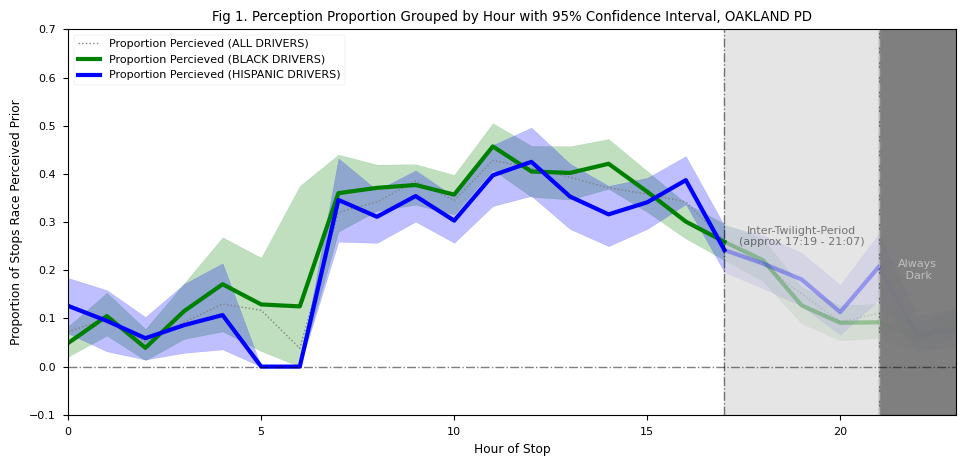

In [578]:
import matplotlib.style as style
style.use('seaborn-paper')
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)


fig, ax = plt.subplots(figsize=(10, 5))
plt.rcParams.update({'font.size': 18, 'lines.linewidth': 3})



# Race Perception All Groups (GREY)
ax.plot(oak_prop_hod2_day['hour'], oak_prop_hod2_day['prop'],c='grey',linewidth=1,linestyle='dotted',label='Proportion Percieved (ALL DRIVERS)')
ax.plot(oak_prop_hod2_itp_dusk['hour'], oak_prop_hod2_itp_dusk['prop'],c='grey',linewidth=1,linestyle='dotted',alpha=.3)
ax.plot(oak_prop_hod2_night['hour'], oak_prop_hod2_night['prop'],linewidth=1,linestyle='dotted',c='grey',alpha=.02)



# Race Perception Black (GREEN)
ax.plot(oak_prop_hod2_day_black['hour'], oak_prop_hod2_day_black['prop'],c='green',label='Proportion Percieved (BLACK DRIVERS)')
ax.plot(oak_prop_hod2_itp_dusk_black['hour'], oak_prop_hod2_itp_dusk_black['prop'],c='green',alpha=.3)
ax.plot(oak_prop_hod2_night_black['hour'], oak_prop_hod2_night_black['prop'],c='green',alpha=.02)

ax.fill_between(oak_prop_hod2_day_black['hour'], 
                oak_prop_hod2_day_black['prop lower ci'], 
                oak_prop_hod2_day_black['prop upper ci'],antialiased=True, color='green', alpha=.25)

ax.fill_between(oak_prop_hod2_itp_dusk_black['hour'], 
                oak_prop_hod2_itp_dusk_black['prop lower ci'], 
                oak_prop_hod2_itp_dusk_black['prop upper ci'],antialiased=True, color='green', alpha=.07)

ax.fill_between(oak_prop_hod2_night_black['hour'], 
                oak_prop_hod2_night_black['prop lower ci'], 
                oak_prop_hod2_night_black['prop upper ci'],antialiased=True, color='green', alpha=.02)




# Race Perception Hispanic (Blue)
ax.plot(oak_prop_hod2_day_hispanic['hour'], oak_prop_hod2_day_hispanic['prop'],c='blue',label='Proportion Percieved (HISPANIC DRIVERS)')
ax.plot(oak_prop_hod2_itp_dusk_hispanic['hour'], oak_prop_hod2_itp_dusk_hispanic['prop'],c='blue',alpha=.3)
ax.plot(oak_prop_hod2_night_hispanic['hour'], oak_prop_hod2_night_hispanic['prop'],c='blue',alpha=.02)

ax.fill_between(oak_prop_hod2_day_hispanic['hour'], 
                oak_prop_hod2_day_hispanic['prop lower ci'], 
                oak_prop_hod2_day_hispanic['prop upper ci'],antialiased=True, color='blue', alpha=.25)

ax.fill_between(oak_prop_hod2_itp_dusk_hispanic['hour'], 
                oak_prop_hod2_itp_dusk_hispanic['prop lower ci'], 
                oak_prop_hod2_itp_dusk_hispanic['prop upper ci'],antialiased=True, color='blue', alpha=.07)

ax.fill_between(oak_prop_hod2_night_hispanic['hour'], 
                oak_prop_hod2_night_hispanic['prop lower ci'], 
                oak_prop_hod2_night_hispanic['prop upper ci'],antialiased=True, color='blue', alpha=.02)




ax.set_ylim(ymin=0)
plt.xlim(0,23)
plt.legend(fontsize=8,loc='upper left', borderaxespad=.5)

plt.axvline(x = 17,c='black',alpha=.5,linestyle='dashdot',linewidth=1)
plt.axvline(x = 21,c='white',alpha=.5,linestyle='dashdot',linewidth=1)
plt.axhline(y = 0,c='black',alpha=.5,linestyle='dashdot',linewidth=1)

plt.axvspan(17, 21, color='black', alpha=0.1)
plt.axvspan(21, 24, color='black', alpha=0.5)
plt.ylim(-.1,.7)

# plt.axvline(x = 6,c='white',alpha=.5,linestyle='dashed',linewidth=1)
# plt.axvline(x = 8,c='black',alpha=.5,linestyle='dashed',linewidth=1)
# plt.axvspan(0, 6, color='black', alpha=0.6)
# plt.axvspan(6, 8, color='black', alpha=0.1)


ax.text(19, 0.27, 'Inter-Twilight-Period\n(approx 17:19 - 21:07)', ha='center', va='center',alpha=.5,fontsize=8)
ax.text(22, 0.2, 'Always\n Dark', ha='center', va='center',alpha=.5,fontsize=8,c='white')

plt.xlabel('Hour of Stop')
plt.ylabel('Proportion of Stops Race Perceived Prior')
ax.set_title('Fig 1. Perception Proportion Grouped by Hour with 95% Confidence Interval, OAKLAND PD')
plt.tight_layout()

In [109]:
# OAK_for_hod2['_Yes'].mean() == OAK_for_hod2['_Yes'].sum()/OAK_for_hod2['_Yes'].shape[0]

## BERK EDA

In [444]:
BERK['race'].unique()

array(['hispanic/latino', 'white', 'black/african american',
       'middle eastern/south asian', 'asian', 'mixed', 'pacific islander'],
      dtype=object)

In [448]:
BERK_for_hod2

,hour,_False,_True
0,11,0,1
1,10,0,1
2,9,0,1
3,22,1,0
4,23,1,0
...,...,...,...
6461,9,1,0
6462,8,0,1
6463,8,0,1
6464,8,0,1


In [458]:
berk_for_hod2 = pd.get_dummies(BERK[['hour','race perceived prior']], columns = ['race perceived prior'], drop_first=False, prefix='')
berk_hod2_yesct = berk_for_hod2.groupby('hour',as_index=False)['_True']\
                           	.sum()\
                           	.rename(columns={'_True':'perceived'})\
                           	.sort_values(by='hour',ascending=False)
                                                  	 
berk_hod2_ct = berk_for_hod2[['hour','_True']].groupby('hour',as_index=False)\
                                         	.count()\
                                         	.rename(columns={'_True':'total stops'})
                                                              	 

berk_prop_hod2 = berk_hod2_yesct.merge(berk_hod2_ct, on = 'hour').sort_values(by='hour',ascending=True).reset_index(drop=True)
berk_prop_hod2['prop'] = [round(i,3) for i in berk_prop_hod2['perceived']/berk_prop_hod2['total stops']]

# berk_prop_hod2['hod2_rounded'] = pd.to_datetime(berk_prop_hod2['hod2_rounded'], format='%H:%M')
# berk_prop_hod2 = berk_prop_hod2.sort_values(by='hod2_rounded', ascending=True).reset_index(drop=True)
berk_prop_hod2['prop lower ci'] = None
berk_prop_hod2['prop upper ci'] = None



for hour in (berk_prop_hod2['hour'].unique()):
	find_hour_percieved_prop_ci95_berk(berk_prop_hod2,berk_for_hod2,hour)
# berk_prop_hod2


In [467]:
berk_for_hod2_black = pd.get_dummies(BERK[BERK['race'].str.lower()=='black/african american'][['hour','race perceived prior']], columns = ['race perceived prior'], drop_first=False, prefix='')
berk_hod2_yesct_black = berk_for_hod2_black.groupby('hour',as_index=False)['_True']\
                           	.sum()\
                           	.rename(columns={'_True':'perceived'})\
                           	.sort_values(by='hour',ascending=False)
                                                  	 
berk_hod2_ct_black = berk_for_hod2_black[['hour','_True']].groupby('hour',as_index=False)\
                                                      	.count()\
                                                      	.rename(columns={'_True':'total stops'})
                                                              	 

berk_prop_hod2_black = berk_hod2_yesct_black.merge(berk_hod2_ct_black, on = 'hour').sort_values(by='hour',ascending=True).reset_index(drop=True)
berk_prop_hod2_black['prop'] = [round(i,3) for i in berk_prop_hod2_black['perceived']/berk_prop_hod2_black['total stops']]

# berk_prop_hod2['hod2_rounded'] = pd.to_datetime(berk_prop_hod2['hod2_rounded'], format='%H:%M')
# berk_prop_hod2 = berk_prop_hod2.sort_values(by='hod2_rounded', ascending=True).reset_index(drop=True)
berk_prop_hod2_black['prop lower ci'] = None
berk_prop_hod2_black['prop upper ci'] = None



for hour in (berk_prop_hod2_black['hour'].unique()):
	find_hour_percieved_prop_ci95_berk(berk_prop_hod2_black,berk_for_hod2_black,hour)
# berk_prop_hod2


In [468]:
berk_prop_hod2_black

,hour,perceived,total stops,prop,prop lower ci,prop upper ci
0,0,7,154,0.045,0.01948,0.07792
1,1,2,109,0.018,0.0,0.04587
2,2,5,112,0.045,0.01786,0.08036
3,3,4,81,0.049,0.01235,0.08642
4,4,4,43,0.093,0.02326,0.16279
5,5,0,9,0.000,0.0,0.0
6,6,4,14,0.286,0.07143,0.5
7,7,11,44,0.250,0.13636,0.36364
8,8,15,47,0.319,0.21277,0.42553
9,9,13,57,0.228,0.14035,0.33333


In [469]:
berk_for_hod2_hispanic = pd.get_dummies(BERK[BERK['race'].str.lower()=='hispanic/latino'][['hour','race perceived prior']], columns = ['race perceived prior'], drop_first=False, prefix='')
berk_hod2_yesct_hispanic = berk_for_hod2_hispanic.groupby('hour',as_index=False)['_True']\
                      		 .sum()\
                      		 .rename(columns={'_True':'perceived'})\
                      		 .sort_values(by='hour',ascending=False)
                                             		 
berk_hod2_ct_hispanic = berk_for_hod2_hispanic[['hour','_True']].groupby('hour',as_index=False)\
                                                 		 .count()\
                                                 		 .rename(columns={'_True':'total stops'})
                                                         		 

berk_prop_hod2_hispanic = berk_hod2_yesct_hispanic.merge(berk_hod2_ct_hispanic, on = 'hour').sort_values(by='hour',ascending=True).reset_index(drop=True)
berk_prop_hod2_hispanic['prop'] = [round(i,3) for i in berk_prop_hod2_hispanic['perceived']/berk_prop_hod2_hispanic['total stops']]

# berk_prop_hod2['hod2_rounded'] = pd.to_datetime(berk_prop_hod2['hod2_rounded'], format='%H:%M')
# berk_prop_hod2 = berk_prop_hod2.sort_values(by='hod2_rounded', ascending=True).reset_index(drop=True)
berk_prop_hod2_hispanic['prop lower ci'] = None
berk_prop_hod2_hispanic['prop upper ci'] = None



for hour in (berk_prop_hod2_hispanic['hour'].unique()):
    find_hour_percieved_prop_ci95_berk(berk_prop_hod2_hispanic,berk_for_hod2_hispanic,hour)
berk_prop_hod2_hispanic

,hour,perceived,total stops,prop,prop lower ci,prop upper ci
0,0,2,74,0.027,0.0,0.05405
1,1,3,57,0.053,0.01754,0.10526
2,2,0,39,0.000,0.0,0.0
3,3,0,29,0.000,0.0,0.0
4,4,0,11,0.000,0.0,0.0
5,5,0,10,0.000,0.0,0.0
6,6,2,9,0.222,0.0,0.44444
7,7,7,36,0.194,0.08333,0.30556
8,8,20,56,0.357,0.25,0.46429
9,9,12,59,0.203,0.11864,0.28814


In [470]:
berk_prop_hod2['hour'] = berk_prop_hod2['hour'].astype(int)
berk_prop_hod2['prop'] = berk_prop_hod2['prop'].astype(float)
berk_prop_hod2['prop lower ci'] = berk_prop_hod2['prop lower ci'].astype(float)
berk_prop_hod2['prop upper ci'] = berk_prop_hod2['prop upper ci'].astype(float)

berk_prop_hod2_day = berk_prop_hod2[(berk_prop_hod2['hour']<=17)]
berk_prop_hod2_itp_dusk = berk_prop_hod2[(berk_prop_hod2['hour']>=17)&(berk_prop_hod2['hour']<=21)]
berk_prop_hod2_night = berk_prop_hod2[(berk_prop_hod2['hour']>=21)]




# berk_prop_hod2_nonwhite black group



berk_prop_hod2_black['hour'] = berk_prop_hod2_black['hour'].astype(int)
berk_prop_hod2_black['prop'] = berk_prop_hod2_black['prop'].astype(float)
berk_prop_hod2_black['prop lower ci'] = berk_prop_hod2_black['prop lower ci'].astype(float)
berk_prop_hod2_black['prop upper ci'] = berk_prop_hod2_black['prop upper ci'].astype(float)

berk_prop_hod2_day_black = berk_prop_hod2_black[(berk_prop_hod2_black['hour']<=17)]
berk_prop_hod2_itp_dusk_black = berk_prop_hod2_black[(berk_prop_hod2_black['hour']>=17)&(berk_prop_hod2_black['hour']<=21)]
berk_prop_hod2_night_black = berk_prop_hod2_black[(berk_prop_hod2_black['hour']>=21)]





# # berk_prop_hod2_nonwhite hispanic group

berk_prop_hod2_hispanic['hour'] = berk_prop_hod2_hispanic['hour'].astype(int)
berk_prop_hod2_hispanic['prop'] = berk_prop_hod2_hispanic['prop'].astype(float)
berk_prop_hod2_hispanic['prop lower ci'] = berk_prop_hod2_hispanic['prop lower ci'].astype(float)
berk_prop_hod2_hispanic['prop upper ci'] = berk_prop_hod2_hispanic['prop upper ci'].astype(float)

berk_prop_hod2_day_hispanic = berk_prop_hod2_hispanic[(berk_prop_hod2_hispanic['hour']<=17)]
berk_prop_hod2_itp_dusk_hispanic = berk_prop_hod2_hispanic[(berk_prop_hod2_hispanic['hour']>=17)&(berk_prop_hod2_hispanic['hour']<=21)]
berk_prop_hod2_night_hispanic = berk_prop_hod2_hispanic[(berk_prop_hod2_hispanic['hour']>=21)]



<Figure size 640x440 with 0 Axes>

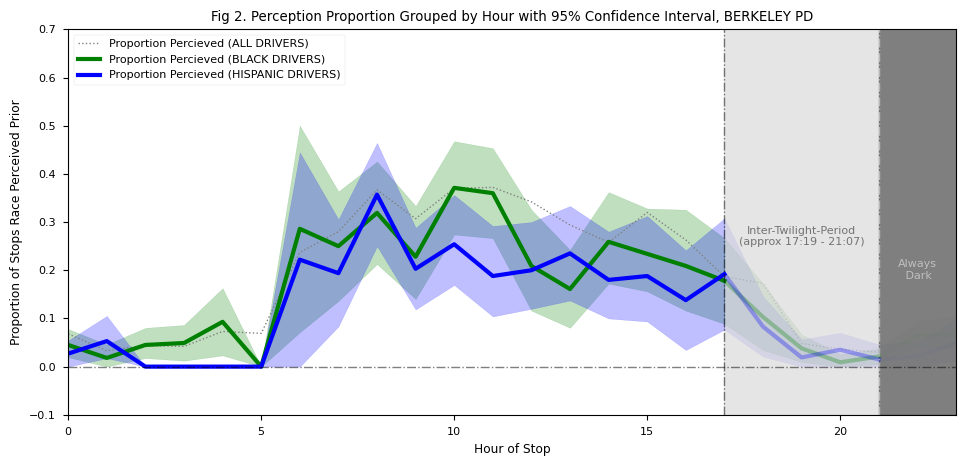

In [577]:
import matplotlib.style as style
style.use('seaborn-paper')
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)


fig, ax = plt.subplots(figsize=(10, 5))
plt.rcParams.update({'font.size': 18, 'lines.linewidth': 3})



# Race Perception All Groups (GREY)
ax.plot(berk_prop_hod2_day['hour'], berk_prop_hod2_day['prop'],c='grey',linewidth=1,linestyle='dotted',label='Proportion Percieved (ALL DRIVERS)')
ax.plot(berk_prop_hod2_itp_dusk['hour'], berk_prop_hod2_itp_dusk['prop'],c='grey',linewidth=1,linestyle='dotted',alpha=.3)
ax.plot(berk_prop_hod2_night['hour'], berk_prop_hod2_night['prop'],linewidth=1,linestyle='dotted',c='grey',alpha=.02)



# Race Perception Black (GREEN)
ax.plot(berk_prop_hod2_day_black['hour'], berk_prop_hod2_day_black['prop'],c='green',label='Proportion Percieved (BLACK DRIVERS)')
ax.plot(berk_prop_hod2_itp_dusk_black['hour'], berk_prop_hod2_itp_dusk_black['prop'],c='green',alpha=.3)
ax.plot(berk_prop_hod2_night_black['hour'], berk_prop_hod2_night_black['prop'],c='green',alpha=.02)

ax.fill_between(berk_prop_hod2_day_black['hour'],
            	berk_prop_hod2_day_black['prop lower ci'],
            	berk_prop_hod2_day_black['prop upper ci'],antialiased=True, color='green', alpha=.25)

ax.fill_between(berk_prop_hod2_itp_dusk_black['hour'],
            	berk_prop_hod2_itp_dusk_black['prop lower ci'],
            	berk_prop_hod2_itp_dusk_black['prop upper ci'],antialiased=True, color='green', alpha=.07)

ax.fill_between(berk_prop_hod2_night_black['hour'],
            	berk_prop_hod2_night_black['prop lower ci'],
            	berk_prop_hod2_night_black['prop upper ci'],antialiased=True, color='green', alpha=.02)




# Race Perception Hispanic (Blue)
ax.plot(berk_prop_hod2_day_hispanic['hour'], berk_prop_hod2_day_hispanic['prop'],c='blue',label='Proportion Percieved (HISPANIC DRIVERS)')
ax.plot(berk_prop_hod2_itp_dusk_hispanic['hour'], berk_prop_hod2_itp_dusk_hispanic['prop'],c='blue',alpha=.3)
ax.plot(berk_prop_hod2_night_hispanic['hour'], berk_prop_hod2_night_hispanic['prop'],c='blue',alpha=.02)

ax.fill_between(berk_prop_hod2_day_hispanic['hour'],
            	berk_prop_hod2_day_hispanic['prop lower ci'],
            	berk_prop_hod2_day_hispanic['prop upper ci'],antialiased=True, color='blue', alpha=.25)

ax.fill_between(berk_prop_hod2_itp_dusk_hispanic['hour'],
            	berk_prop_hod2_itp_dusk_hispanic['prop lower ci'],
            	berk_prop_hod2_itp_dusk_hispanic['prop upper ci'],antialiased=True, color='blue', alpha=.07)

ax.fill_between(berk_prop_hod2_night_hispanic['hour'],
            	berk_prop_hod2_night_hispanic['prop lower ci'],
            	berk_prop_hod2_night_hispanic['prop upper ci'],antialiased=True, color='blue', alpha=.02)




ax.set_ylim(ymin=0)
plt.xlim(0,23)
plt.legend(fontsize=8,loc='upper left', borderaxespad=.5)

plt.axvline(x = 17,c='black',alpha=.5,linestyle='dashdot',linewidth=1)
plt.axvline(x = 21,c='white',alpha=.5,linestyle='dashdot',linewidth=1)
plt.axhline(y = 0,c='black',alpha=.5,linestyle='dashdot',linewidth=1)

plt.axvspan(17, 21, color='black', alpha=0.1)
plt.axvspan(21, 24, color='black', alpha=0.5)
plt.ylim(-.1,.7)

# plt.axvline(x = 6,c='white',alpha=.5,linestyle='dashed',linewidth=1)
# plt.axvline(x = 8,c='black',alpha=.5,linestyle='dashed',linewidth=1)
# plt.axvspan(0, 6, color='black', alpha=0.6)
# plt.axvspan(6, 8, color='black', alpha=0.1)


ax.text(19, 0.27, 'Inter-Twilight-Period\n(approx 17:19 - 21:07)', ha='center', va='center',alpha=.5,fontsize=8)
ax.text(22, 0.2, 'Always\n Dark', ha='center', va='center',alpha=.5,fontsize=8,c='white')

plt.xlabel('Hour of Stop')
plt.ylabel('Proportion of Stops Race Perceived Prior')
ax.set_title('Fig 2. Perception Proportion Grouped by Hour with 95% Confidence Interval, BERKELEY PD')
plt.tight_layout()


## MARIN EDA

In [477]:
MARIN['race perceived prior'].unique()

array(['No', 'Yes'], dtype=object)

In [489]:
MARIN['race'].unique()

array(['hispanic/latino(a)', 'black/african american', 'white', 'asian',
       'middle eastern or south asian', 'pacific islander',
       'native american'], dtype=object)

In [486]:
# ALL DRIVERS
marin_for_hod2 = pd.get_dummies(MARIN[['hour','race perceived prior']], columns = ['race perceived prior'], drop_first=False, prefix='')
marin_hod2_yesct = marin_for_hod2.groupby('hour',as_index=False)['_Yes']\
                      		 .sum()\
                      		 .rename(columns={'_Yes':'perceived'})\
                      		 .sort_values(by='hour',ascending=False)
                                             		 
marin_hod2_ct = marin_for_hod2[['hour','_Yes']].groupby('hour',as_index=False)\
                                    		 .count()\
                                    		 .rename(columns={'_Yes':'total stops'})
                                                         		 

marin_prop_hod2 = marin_hod2_yesct.merge(marin_hod2_ct, on = 'hour').sort_values(by='hour',ascending=True).reset_index(drop=True)
marin_prop_hod2['prop'] = [round(i,3) for i in marin_prop_hod2['perceived']/marin_prop_hod2['total stops']]

# marin_prop_hod2['hod2_rounded'] = pd.to_datetime(marin_prop_hod2['hod2_rounded'], format='%H:%M')
# marin_prop_hod2 = marin_prop_hod2.sort_values(by='hod2_rounded', ascending=True).reset_index(drop=True)
marin_prop_hod2['prop lower ci'] = None
marin_prop_hod2['prop upper ci'] = None



for hour in (marin_prop_hod2['hour'].unique()):
    find_hour_percieved_prop_ci95_marin(marin_prop_hod2,marin_for_hod2,hour)





# BLACK DRIVERS
marin_for_hod2_black = pd.get_dummies(MARIN[MARIN['race'].str.lower()=='black/african american'][['hour','race perceived prior']], columns = ['race perceived prior'], drop_first=False, prefix='')
marin_hod2_yesct_black = marin_for_hod2_black.groupby('hour',as_index=False)['_Yes']\
                      		 .sum()\
                      		 .rename(columns={'_Yes':'perceived'})\
                      		 .sort_values(by='hour',ascending=False)
                                             		 
marin_hod2_ct_black = marin_for_hod2_black[['hour','_Yes']].groupby('hour',as_index=False)\
                                                 		 .count()\
                                                 		 .rename(columns={'_Yes':'total stops'})
                                                         		 

marin_prop_hod2_black = marin_hod2_yesct_black.merge(marin_hod2_ct_black, on = 'hour').sort_values(by='hour',ascending=True).reset_index(drop=True)
marin_prop_hod2_black['prop'] = [round(i,3) for i in marin_prop_hod2_black['perceived']/marin_prop_hod2_black['total stops']]

marin_prop_hod2_black['prop lower ci'] = None
marin_prop_hod2_black['prop upper ci'] = None


for hour in (marin_prop_hod2_black['hour'].unique()):
    find_hour_percieved_prop_ci95_marin(marin_prop_hod2_black,marin_for_hod2_black,hour)





# HISPANIC DRIVERS
marin_for_hod2_hispanic = pd.get_dummies(MARIN[MARIN['race'].str.lower()=='hispanic/latino(a)'][['hour','race perceived prior']], columns = ['race perceived prior'], drop_first=False, prefix='')
marin_hod2_yesct_hispanic = marin_for_hod2_hispanic.groupby('hour',as_index=False)['_Yes']\
                 			  .sum()\
                 			  .rename(columns={'_Yes':'perceived'})\
                 			  .sort_values(by='hour',ascending=False)
                                        			 
marin_hod2_ct_hispanic = marin_for_hod2_hispanic[['hour','_Yes']].groupby('hour',as_index=False)\
                                            			  .count()\
                                            			  .rename(columns={'_Yes':'total stops'})
                                                    			 

marin_prop_hod2_hispanic = marin_hod2_yesct_hispanic.merge(marin_hod2_ct_hispanic, on = 'hour').sort_values(by='hour',ascending=True).reset_index(drop=True)
marin_prop_hod2_hispanic['prop'] = [round(i,3) for i in marin_prop_hod2_hispanic['perceived']/marin_prop_hod2_hispanic['total stops']]

marin_prop_hod2_hispanic['prop lower ci'] = None
marin_prop_hod2_hispanic['prop upper ci'] = None


for hour in (marin_prop_hod2_hispanic['hour'].unique()):
	find_hour_percieved_prop_ci95_marin(marin_prop_hod2_hispanic,marin_for_hod2_hispanic,hour)
marin_prop_hod2_hispanic

,hour,perceived,total stops,prop,prop lower ci,prop upper ci
0,0,1,60,0.017,0.0,0.05
1,1,1,50,0.020,0.0,0.06
2,2,0,29,0.000,0.0,0.0
3,3,1,24,0.042,0.0,0.125
4,4,0,11,0.000,0.0,0.0
5,5,0,3,0.000,0.0,0.0
6,6,1,2,0.500,0.0,1.0
7,7,1,11,0.091,0.0,0.27273
8,8,2,23,0.087,0.0,0.17391
9,9,2,33,0.061,0.0,0.12121


In [487]:
marin_prop_hod2['hour'] = marin_prop_hod2['hour'].astype(int)
marin_prop_hod2['prop'] = marin_prop_hod2['prop'].astype(float)
marin_prop_hod2['prop lower ci'] = marin_prop_hod2['prop lower ci'].astype(float)
marin_prop_hod2['prop upper ci'] = marin_prop_hod2['prop upper ci'].astype(float)

marin_prop_hod2_day = marin_prop_hod2[(marin_prop_hod2['hour']<=17)]
marin_prop_hod2_itp_dusk = marin_prop_hod2[(marin_prop_hod2['hour']>=17)&(marin_prop_hod2['hour']<=21)]
marin_prop_hod2_night = marin_prop_hod2[(marin_prop_hod2['hour']>=21)]




# marin_prop_hod2_nonwhite black group



marin_prop_hod2_black['hour'] = marin_prop_hod2_black['hour'].astype(int)
marin_prop_hod2_black['prop'] = marin_prop_hod2_black['prop'].astype(float)
marin_prop_hod2_black['prop lower ci'] = marin_prop_hod2_black['prop lower ci'].astype(float)
marin_prop_hod2_black['prop upper ci'] = marin_prop_hod2_black['prop upper ci'].astype(float)

marin_prop_hod2_day_black = marin_prop_hod2_black[(marin_prop_hod2_black['hour']<=17)]
marin_prop_hod2_itp_dusk_black = marin_prop_hod2_black[(marin_prop_hod2_black['hour']>=17)&(marin_prop_hod2_black['hour']<=21)]
marin_prop_hod2_night_black = marin_prop_hod2_black[(marin_prop_hod2_black['hour']>=21)]





# # marin_prop_hod2_nonwhite hispanic group

marin_prop_hod2_hispanic['hour'] = marin_prop_hod2_hispanic['hour'].astype(int)
marin_prop_hod2_hispanic['prop'] = marin_prop_hod2_hispanic['prop'].astype(float)
marin_prop_hod2_hispanic['prop lower ci'] = marin_prop_hod2_hispanic['prop lower ci'].astype(float)
marin_prop_hod2_hispanic['prop upper ci'] = marin_prop_hod2_hispanic['prop upper ci'].astype(float)

marin_prop_hod2_day_hispanic = marin_prop_hod2_hispanic[(marin_prop_hod2_hispanic['hour']<=17)]
marin_prop_hod2_itp_dusk_hispanic = marin_prop_hod2_hispanic[(marin_prop_hod2_hispanic['hour']>=17)&(marin_prop_hod2_hispanic['hour']<=21)]
marin_prop_hod2_night_hispanic = marin_prop_hod2_hispanic[(marin_prop_hod2_hispanic['hour']>=21)]

<Figure size 640x440 with 0 Axes>

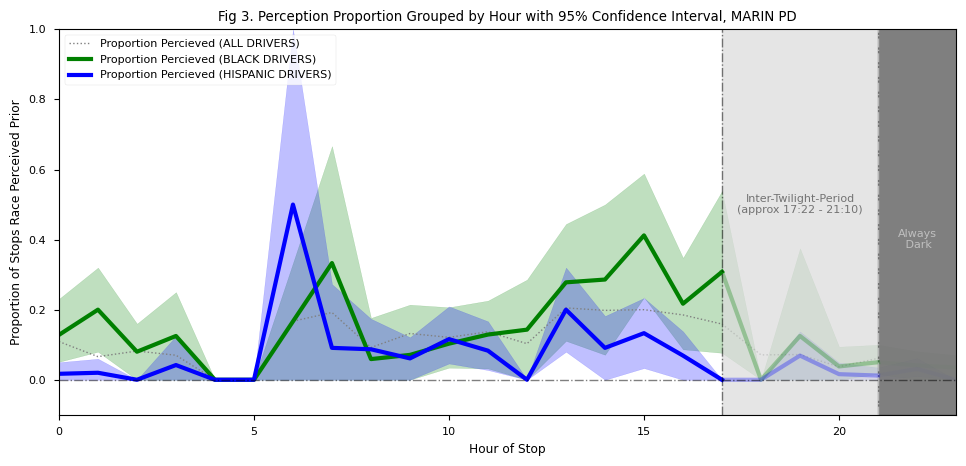

In [576]:
import matplotlib.style as style
style.use('seaborn-paper')
plt.subplots_adjust(left=0.15, right=0.95, top=0.9, bottom=0.1)


fig, ax = plt.subplots(figsize=(10, 5))
plt.rcParams.update({'font.size': 18, 'lines.linewidth': 3})



# Race Perception All Groups (GREY)
ax.plot(marin_prop_hod2_day['hour'], marin_prop_hod2_day['prop'],c='grey',linewidth=1,linestyle='dotted',label='Proportion Percieved (ALL DRIVERS)')
ax.plot(marin_prop_hod2_itp_dusk['hour'], marin_prop_hod2_itp_dusk['prop'],c='grey',linewidth=1,linestyle='dotted',alpha=.3)
ax.plot(marin_prop_hod2_night['hour'], marin_prop_hod2_night['prop'],linewidth=1,linestyle='dotted',c='grey',alpha=.02)



# Race Perception Black (GREEN)
ax.plot(marin_prop_hod2_day_black['hour'], marin_prop_hod2_day_black['prop'],c='green',label='Proportion Percieved (BLACK DRIVERS)')
ax.plot(marin_prop_hod2_itp_dusk_black['hour'], marin_prop_hod2_itp_dusk_black['prop'],c='green',alpha=.3)
ax.plot(marin_prop_hod2_night_black['hour'], marin_prop_hod2_night_black['prop'],c='green',alpha=.02)

ax.fill_between(marin_prop_hod2_day_black['hour'],
       		 marin_prop_hod2_day_black['prop lower ci'],
       		 marin_prop_hod2_day_black['prop upper ci'],antialiased=True, color='green', alpha=.25)

ax.fill_between(marin_prop_hod2_itp_dusk_black['hour'],
       		 marin_prop_hod2_itp_dusk_black['prop lower ci'],
       		 marin_prop_hod2_itp_dusk_black['prop upper ci'],antialiased=True, color='green', alpha=.07)

ax.fill_between(marin_prop_hod2_night_black['hour'],
       		 marin_prop_hod2_night_black['prop lower ci'],
       		 marin_prop_hod2_night_black['prop upper ci'],antialiased=True, color='green', alpha=.02)




# Race Perception Hispanic (Blue)
ax.plot(marin_prop_hod2_day_hispanic['hour'], marin_prop_hod2_day_hispanic['prop'],c='blue',label='Proportion Percieved (HISPANIC DRIVERS)')
ax.plot(marin_prop_hod2_itp_dusk_hispanic['hour'], marin_prop_hod2_itp_dusk_hispanic['prop'],c='blue',alpha=.3)
ax.plot(marin_prop_hod2_night_hispanic['hour'], marin_prop_hod2_night_hispanic['prop'],c='blue',alpha=.02)

ax.fill_between(marin_prop_hod2_day_hispanic['hour'],
       		 marin_prop_hod2_day_hispanic['prop lower ci'],
       		 marin_prop_hod2_day_hispanic['prop upper ci'],antialiased=True, color='blue', alpha=.25)

ax.fill_between(marin_prop_hod2_itp_dusk_hispanic['hour'],
       		 marin_prop_hod2_itp_dusk_hispanic['prop lower ci'],
       		 marin_prop_hod2_itp_dusk_hispanic['prop upper ci'],antialiased=True, color='blue', alpha=.07)

ax.fill_between(marin_prop_hod2_night_hispanic['hour'],
       		 marin_prop_hod2_night_hispanic['prop lower ci'],
       		 marin_prop_hod2_night_hispanic['prop upper ci'],antialiased=True, color='blue', alpha=.02)




ax.set_ylim(ymin=0)
plt.xlim(0,23)
plt.legend(fontsize=8,loc='upper left', borderaxespad=.5)

plt.axvline(x = 17,c='black',alpha=.5,linestyle='dashdot',linewidth=1)
plt.axvline(x = 21,c='white',alpha=.5,linestyle='dashdot',linewidth=1)
plt.axhline(y = 0,c='black',alpha=.5,linestyle='dashdot',linewidth=1)

plt.axvspan(17, 21, color='black', alpha=0.1)
plt.axvspan(21, 24, color='black', alpha=0.5)
plt.ylim(-.1,1)

# plt.axvline(x = 6,c='white',alpha=.5,linestyle='dashed',linewidth=1)
# plt.axvline(x = 8,c='black',alpha=.5,linestyle='dashed',linewidth=1)
# plt.axvspan(0, 6, color='black', alpha=0.6)
# plt.axvspan(6, 8, color='black', alpha=0.1)


ax.text(19, 0.5, 'Inter-Twilight-Period\n(approx 17:22 - 21:10)', ha='center', va='center',alpha=.5,fontsize=8)
ax.text(22, 0.4, 'Always\n Dark', ha='center', va='center',alpha=.5,fontsize=8,c='white')

plt.xlabel('Hour of Stop')
plt.ylabel('Proportion of Stops Race Perceived Prior')
ax.set_title('Fig 3. Perception Proportion Grouped by Hour with 95% Confidence Interval, MARIN PD')
plt.tight_layout()

In [109]:
# OAK_for_hod2['_Yes'].mean() == OAK_for_hod2['_Yes'].sum()/OAK_for_hod2['_Yes'].shape[0]

In [492]:
marin_prop_hod2_hispanic

,hour,perceived,total stops,prop,prop lower ci,prop upper ci
0,0,1,60,0.017,0.00000,0.05000
1,1,1,50,0.020,0.00000,0.06000
2,2,0,29,0.000,0.00000,0.00000
3,3,1,24,0.042,0.00000,0.12500
4,4,0,11,0.000,0.00000,0.00000
5,5,0,3,0.000,0.00000,0.00000
6,6,1,2,0.500,0.00000,1.00000
7,7,1,11,0.091,0.00000,0.27273
8,8,2,23,0.087,0.00000,0.17391
9,9,2,33,0.061,0.00000,0.12121


## T-Test

In [547]:
from scipy.stats import ttest_ind

In [570]:
light = pd.get_dummies(OAK[(OAK['dark']==0)&(OAK['time']>='09:00:00')&(OAK['itp']!=1)], columns = ['race perceived prior'],\
                           drop_first=False, prefix='').rename(columns={'_Yes':'perceived'})['perceived']

 
dark = pd.get_dummies(OAK[OAK['dark']==1], columns = ['race perceived prior'],\
                          drop_first=False, prefix='').rename(columns={'_Yes':'perceived'})['perceived']

print(f"light var: {np.var(light)}\ndark var: {np.var(dark)}\n\n")

t_value,p_value=stats.ttest_ind(light,dark,equal_var=True)

print('Test statistic is %f'%float("{:.6f}".format(t_value)))

print('p-value for two tailed test is %f'%p_value)

light var: 0.22078623727382074
dark var: 0.08012850645584689


Test statistic is 20.969964
p-value for two tailed test is 0.000000


In [572]:
light = pd.get_dummies(BERK[(BERK['dark']==0)&(BERK['time']>='09:00:00')&(BERK['itp']!=1)], columns = ['race perceived prior'],\
                           drop_first=False, prefix='').rename(columns={'_True':'perceived'})['perceived']

 
dark = pd.get_dummies(BERK[BERK['dark']==1], columns = ['race perceived prior'],\
                          drop_first=False, prefix='').rename(columns={'_True':'perceived'})['perceived']

print(f"light var: {np.var(light)}\ndark var: {np.var(dark)}\n\n")

t_value,p_value=stats.ttest_ind(light,dark,equal_var=True)

print('Test statistic is %f'%float("{:.6f}".format(t_value)))

print('p-value for two tailed test is %f'%p_value)

light var: 0.18228058603352174
dark var: 0.04307415183538335


Test statistic is 19.164844
p-value for two tailed test is 0.000000


In [574]:
light = pd.get_dummies(MARIN[(MARIN['dark']==0)&(MARIN['time']>='09:00:00')&(MARIN['itp']!=1)], columns = ['race perceived prior'],\
                       drop_first=False, prefix='').rename(columns={'_Yes':'perceived'})['perceived']

 
dark = pd.get_dummies(MARIN[MARIN['dark']==1], columns = ['race perceived prior'],\
                      drop_first=False, prefix='').rename(columns={'_Yes':'perceived'})['perceived']

print(f"light var: {np.var(light)}\ndark var: {np.var(dark)}\n\n")

t_value,p_value=stats.ttest_ind(light,dark,equal_var=False)


print('Test statistic is %f'%float("{:.6f}".format(t_value)))

print('p-value for two tailed test is %f'%p_value)

light var: 0.11256186536635256
dark var: 0.05586287033434761


Test statistic is 6.818917
p-value for two tailed test is 0.000000


In [575]:
print(len(light),len(dark))

1872 1246
